## 1. Repeat Gradient descent with two (and more) variables.

We will begin by implementing a gradient descent for a simple two-variable linear regression problem and try to verify convergence and some kind of error reduction.

We Begin by importing all dependencies 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# verify everything is working

We can begin the implementation by generating the data needed for this demonstration. I use a fixed seed for reproducability and also use the same true model $y = 2x - 3$ as the example used. I then plot it on a 2D surface just to kind of visualize it.

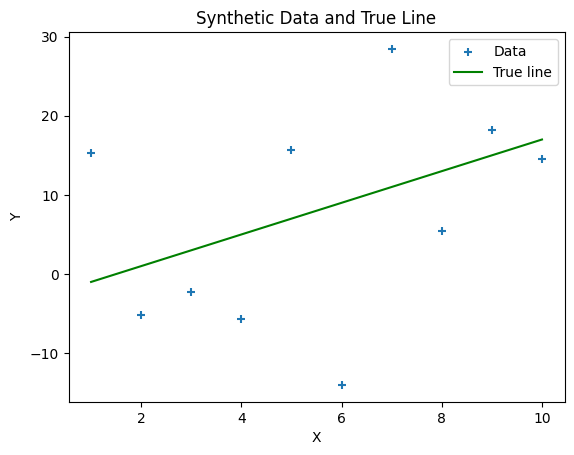

In [34]:
# 1. Generate synthetic data
np.random.seed(1)
N = 10
true_a, true_b = 2, -3
X = np.arange(1, N+1)
Y = true_a * X + true_b + np.random.normal(0, 10, size=N)

# Plot data and true line
plt.figure()
plt.scatter(X, Y, marker='+', label='Data')
plt.plot(X, true_a*X + true_b, color='g', label='True line')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Data and True Line')
plt.legend()
plt.show()


The gradient componentes are the partial derivatives of the loss function with respect to each parameter. When visualizing the RSS surface on a 3D plot we can see that we get a plane that has bowl shaped surface. This surface will show a single minimum near the true parameters.

We can create the level curves that look like ellipses. Theese elipses are also centered around the minimum point. The level curve plot is actually the same plot as the 3D "bowl" but from a top eagle-eye perspective and each line is just a way to illustrate that how "steep" it is. It is kind of the same thing as if you were looking at a map when doing orienteering in order to identify where there are steep hills in a forest.

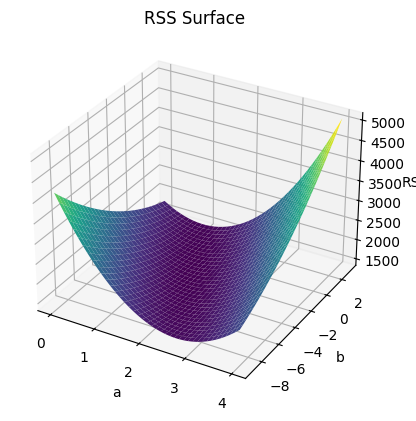

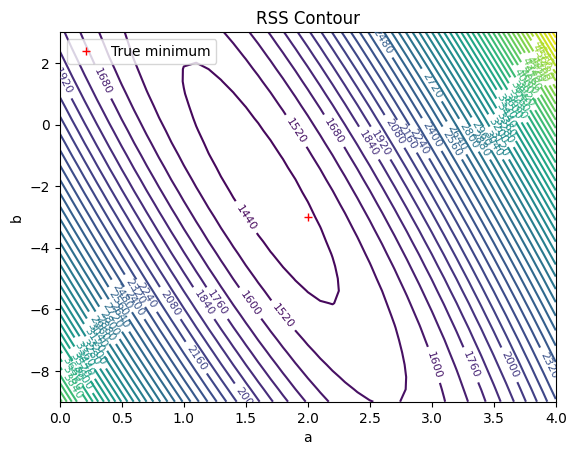

In [35]:
# 2. Define RSS and its gradient

def rss2(a, b, X, Y):
    """Residual sum of squares for parameters a, b."""
    return np.sum((Y - (a*X + b))**2)


def grad_rss2(a, b, X, Y):
    """Gradient of RSS with respect to a and b."""
    residuals = Y - (a*X + b)
    d_a = -2 * np.sum(residuals * X)
    d_b = -2 * np.sum(residuals)
    return d_a, d_b

# 3. Visualize RSS surface and contour
# Create a grid of (a, b) values
a_vals = np.arange(true_a-2, true_a+2.1, 0.1)
b_vals = np.arange(true_b-6, true_b+6.1, 0.4)
A, B = np.meshgrid(a_vals, b_vals)

# Vectorize rss2 to compute F on the grid
rss2_vec = np.vectorize(lambda aa, bb: rss2(aa, bb, X, Y))
F = rss2_vec(A, B)

# 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, F, cmap='viridis', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RSS')
ax.set_title('RSS Surface')
plt.show()

# Contour plot with true minimum
plt.figure()
contours = plt.contour(A, B, F, levels=50)
plt.clabel(contours, inline=True, fontsize=8)
plt.plot(true_a, true_b, '+', color='r', label='True minimum')
plt.xlabel('a')
plt.ylabel('b')
plt.title('RSS Contour')
plt.legend()
plt.show()


We can now implement the gradient descent.

Gradient descent can optimize for different functions but in this case we plot the RSS which is a function of the two parameters `a` and `b`. This will generate the surface we have already seen and at this surface the absolute lowest point is the best fitting line. So we check the gradient of RSS(a, b) and we check for the steepest increase of the RSS but because we want to have a small arrow/vector, the algorithm will make a step against this arrow.

The learning rate will determine how big steps we make so too big of a learning rate will make us overshoot the bottom but a too small will make us crawl very slowly and make the algorithms inefficient.

We can actually plot the behavior of the algorithm, and it will generate the blue looking triangle in the next contour plot which is actually a bunch of zig-zagging lines that show how the algorithm attempts to find the minimum point.

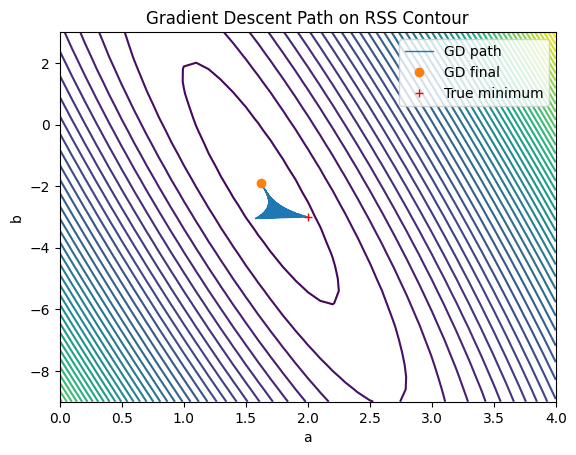

Estimated parameters: a=1.62, b=-1.90
Final loss: 1406.49


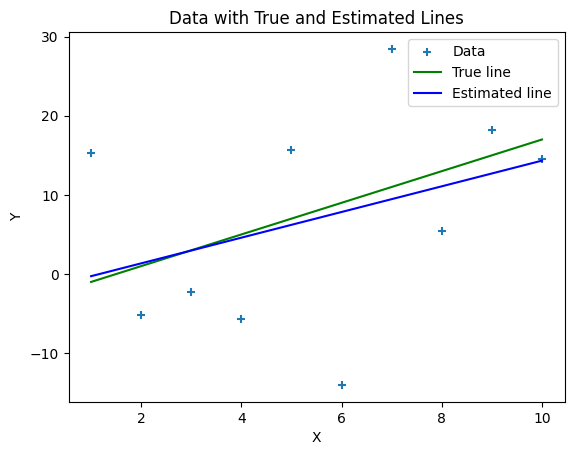

In [36]:
# 4. Gradient descent implementation
def grad_desc_rss2(K, a_init, b_init, lr, X, Y):
    """Performs K steps of gradient descent on RSS starting at (a_init, b_init)."""
    a, b = a_init, b_init
    a_hist = [a]
    b_hist = [b]
    for _ in range(K):
        d_a, d_b = grad_rss2(a, b, X, Y)
        a -= lr * d_a
        b -= lr * d_b
        a_hist.append(a)
        b_hist.append(b)
    return np.array(a_hist), np.array(b_hist)

# Run gradient descent
K = 1000
learning_rate = 0.0025
a_hist, b_hist = grad_desc_rss2(K, true_a, true_b, learning_rate, X, Y)

# Plot optimization path on contour
plt.figure()
plt.contour(A, B, F, levels=50)
plt.plot(a_hist, b_hist, '-', linewidth=1, label='GD path')
plt.plot(a_hist[-1], b_hist[-1], 'o', label='GD final')
plt.plot(true_a, true_b, '+', color='r', label='True minimum')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Gradient Descent Path on RSS Contour')
plt.legend()
plt.show()

# Report final estimates and plot fit
est_a, est_b = a_hist[-1], b_hist[-1]
print(f"Estimated parameters: a={est_a:.2f}, b={est_b:.2f}")
print(f"Final loss: {rss2(est_a, est_b, X, Y):.2f}")

plt.figure()
plt.scatter(X, Y, marker='+', label='Data')
plt.plot(X, true_a*X + true_b, color='g', label='True line')
plt.plot(X, est_a*X + est_b, color='b', label='Estimated line')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with True and Estimated Lines')
plt.legend()
plt.show()


## 1.2 Regularization with the $L^2$ norm

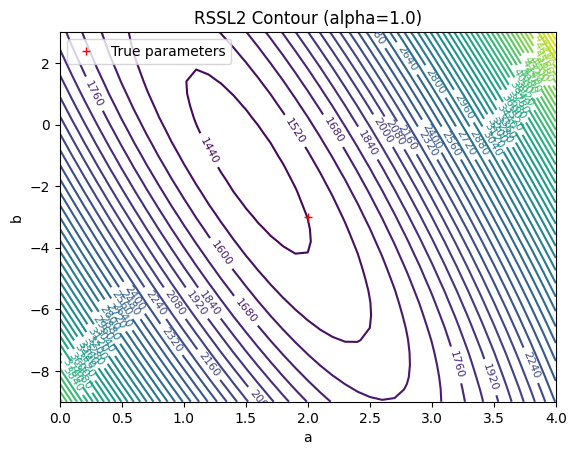

In [37]:
# ### 5. Regularization with the L2 Norm (Ridge)
# We add a penalty alpha*(a^2 + b^2) to the loss to discourage large parameters.

def rss2_l2(a, b, X, Y, alpha):
    return rss2(a, b, X, Y) + alpha*(a**2 + b**2)

def grad_rss2_l2(a, b, X, Y, alpha):
    d_a, d_b = grad_rss2(a, b, X, Y)
    return d_a + 2*alpha*a, d_b + 2*alpha*b

# Choose a penalty strength
alpha = 1.0

# Compute penalized surface for contour
fL2_vec = np.vectorize(lambda aa, bb: rss2_l2(aa, bb, X, Y, alpha))
F_l2 = fL2_vec(A, B)

# Contour of penalized loss
plt.figure()
contours = plt.contour(A, B, F_l2, levels=50)
plt.clabel(contours, inline=True, fontsize=8)
plt.plot(true_a, true_b, '+', color='r', label='True parameters')
plt.xlabel('a')
plt.ylabel('b')
plt.title(f'RSSL2 Contour (alpha={alpha})')
plt.legend()
plt.show()
# **Interpretation**: The penalty pulls the minimum toward (0,0), shrinking parameters.

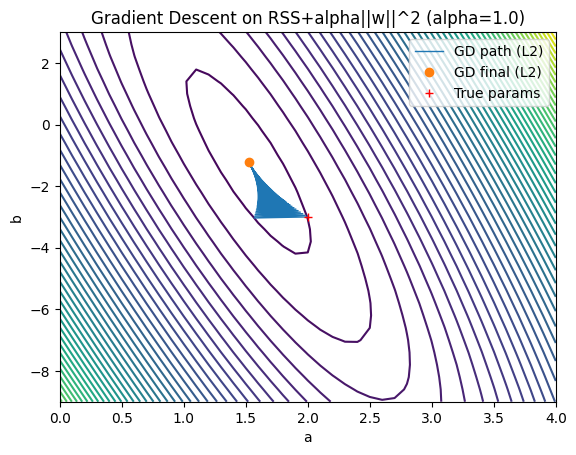

In [38]:
# Gradient descent with L2 penalty
def grad_desc_rss2_l2(K, a_init, b_init, lr, X, Y, alpha):
    a, b = a_init, b_init
    a_hist, b_hist = [a], [b]
    for _ in range(K):
        d_a, d_b = grad_rss2_l2(a, b, X, Y, alpha)
        a -= lr * d_a
        b -= lr * d_b
        a_hist.append(a)
        b_hist.append(b)
    return np.array(a_hist), np.array(b_hist)

# Run penalized gradient descent
a_hist_l2, b_hist_l2 = grad_desc_rss2_l2(K, true_a, true_b, learning_rate, X, Y, alpha)

# Plot path on L2 contour
plt.figure()
plt.contour(A, B, F_l2, levels=50)
plt.plot(a_hist_l2, b_hist_l2, '-', linewidth=1, label='GD path (L2)')
plt.plot(a_hist_l2[-1], b_hist_l2[-1], 'o', label='GD final (L2)')
plt.plot(true_a, true_b, '+', color='r', label='True params')
plt.xlabel('a')
plt.ylabel('b')
plt.title(f'Gradient Descent on RSS+alpha||w||^2 (alpha={alpha})')
plt.legend()
plt.show()


L2-regularized estimates (alpha=1.0): a=1.52, b=-1.22
Unregularized loss on noisy data: 1406.49
Penalized loss: 1411.28


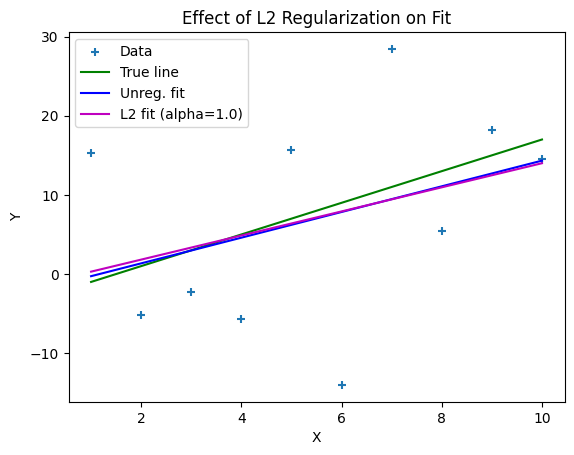

In [39]:
# Report L2-regularized fit and overlay
est_a_l2, est_b_l2 = a_hist_l2[-1], b_hist_l2[-1]
print(f"L2-regularized estimates (alpha={alpha}): a={est_a_l2:.2f}, b={est_b_l2:.2f}")
print(f"Unregularized loss on noisy data: {rss2(est_a, est_b, X, Y):.2f}")
print(f"Penalized loss: {rss2_l2(est_a_l2, est_b_l2, X, Y, alpha):.2f}")

plt.figure()
plt.scatter(X, Y, marker='+', label='Data')
plt.plot(X, true_a*X + true_b, color='g', label='True line')
plt.plot(X, est_a*X + est_b, color='b', label='Unreg. fit')
plt.plot(X, est_a_l2*X + est_b_l2, color='m', label=f'L2 fit (alpha={alpha})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Effect of L2 Regularization on Fit')
plt.legend()
plt.show()
# **Interpretation**: Compared to the unregularized fit, the L2-penalized line has
# slope & intercept closer to zero, reducing variance at the cost of increased training loss.

## 1.5 Regularization with the $L^2$ norm constraint

[Equality GD] a=1.1679, b=0.0911, alpha=56.3282, RSS=1426.19


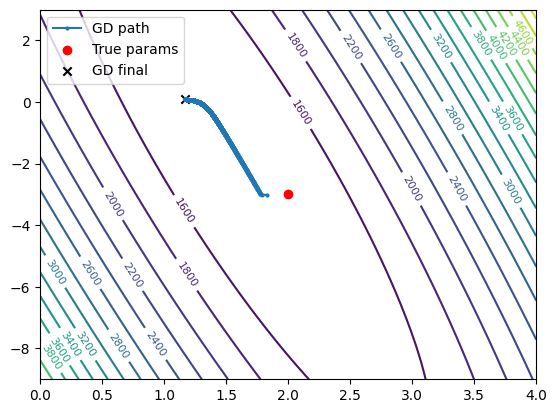

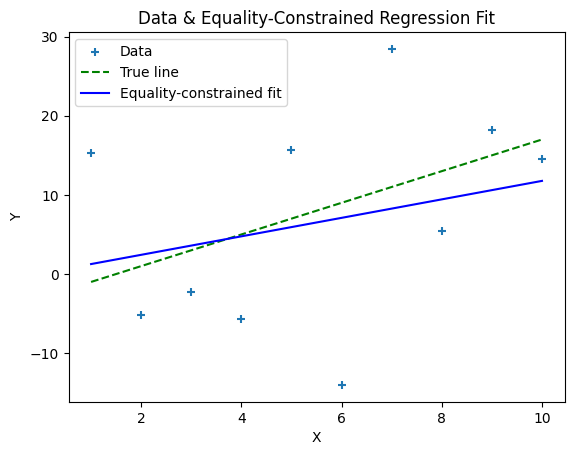

In [48]:
# 4.1 L2-Norm Equality Constraint
# -------------------------------
# Lagrangian gradient for equality constraint

c = (true_a+1)**2 + (true_b+1)**2

# Unconstrained RSS function
def rss(a,b): return np.sum((Y - (a*X + b))**2)

def grad_rss3e(a, b, alpha, c, X, Y):
    # compute unregularized grads
    res = Y - (a*X + b)
    grad_a = -2 * np.sum(res * X) + 2*alpha*a
    grad_b = -2 * np.sum(res)     + 2*alpha*b
    grad_alpha = a*a + b*b - c
    return grad_a, grad_b, grad_alpha

# Gradient descent on L(a,b,alpha)

def grad_desc_rss3e(K, a0, b0, alpha0, lr, c, X, Y):
    a, b, alpha = a0, b0, alpha0
    hist = {'a':[], 'b':[], 'alpha':[]}
    for _ in range(K):
        da, db, dalpha = grad_rss3e(a, b, alpha, c, X, Y)
        a -= lr * da

        b -= lr * db
        alpha -= lr * dalpha
        hist['a'].append(a); hist['b'].append(b); hist['alpha'].append(alpha)
    return hist

# Run equality-constrained gradient descent
K_eq = 5000
lr_eq = 0.001
hist_eq = grad_desc_rss3e(K_eq, true_a, true_b, alpha0=1.0, lr=lr_eq, c=c, X=X, Y=Y)
a_eq, b_eq, alpha_eq = hist_eq['a'][-1], hist_eq['b'][-1], hist_eq['alpha'][-1]
print(f"[Equality GD] a={a_eq:.4f}, b={b_eq:.4f}, alpha={alpha_eq:.4f}, RSS={rss(a_eq,b_eq):.2f}")

# Grid for contour
# Create a grid of (a, b) values around the true parameters
a_vals = np.linspace(true_a-2, true_a+2, 100)
b_vals = np.linspace(true_b-6, true_b+6, 100)
A, B = np.meshgrid(a_vals, b_vals)
F = np.vectorize(lambda aa, bb: rss(aa, bb))(A, B)

# 1) Plot elliptical level curves of the RSS and overlay the GD path
plt.figure()
CS = plt.contour(A, B, F, levels=20)
plt.clabel(CS, inline=1, fontsize=8)
plt.plot(hist_eq['a'], hist_eq['b'], '-o', markersize=2, label='GD path')
plt.scatter(true_a, true_b, color='r', label='True params')
plt.scatter(a_eq, b_eq, color='k', marker='x', label='GD final')

plt.legend()
plt.show()

# 2) 2D plot: data with the constrained fit line
plt.figure()
plt.scatter(X, Y, marker='+', label='Data')
plt.plot(X, true_a*X + true_b, 'g--', label='True line')
plt.plot(X, a_eq*X + b_eq, 'b-', label='Equality-constrained fit')
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Data & Equality-Constrained Regression Fit')
plt.legend(); plt.show()



[Equality GD] a=1.1679, b=0.0911, alpha=56.3282, RSS=1426.19


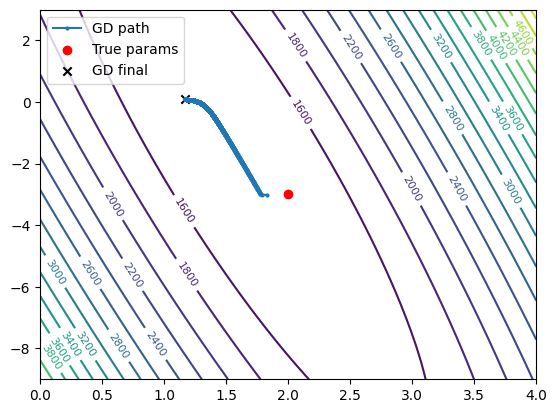

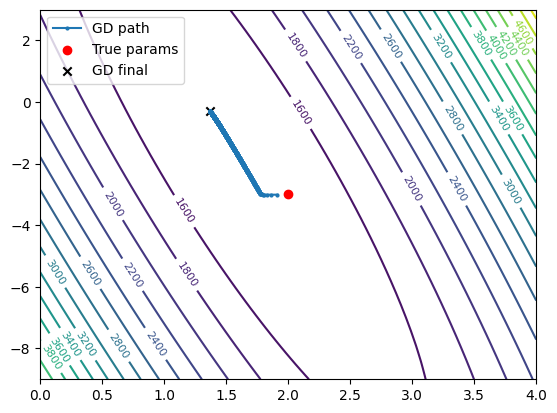

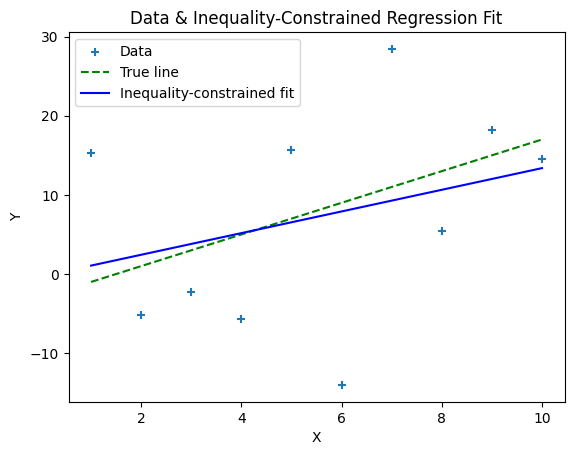

In [54]:
# 4.2 L2-Norm Inequality Constraint
# ----------------------------------
# Augmented Lagrangian with slack s: a^2 + b^2 - c + s^2 = 0

def grad_rss3(a, b, alpha, s, c, X, Y):
    res = Y - (a*X + b)
    grad_a = -2 * np.sum(res * X) + 2*alpha*a
    grad_b = -2 * np.sum(res)     + 2*alpha*b
    grad_alpha = a*a + b*b - c + s*s
    grad_s     = 2*alpha*s
    return grad_a, grad_b, grad_alpha, grad_s

# Gradient descent on augmented Lagrangian

def grad_desc_rss3(K, a0, b0, alpha0, s0, lr, c, X, Y):
    a, b, alpha, s = a0, b0, alpha0, s0
    hist = {'a':[], 'b':[], 'alpha':[], 's':[]}
    for _ in range(K):
        da, db, dalpha, ds = grad_rss3(a, b, alpha, s, c, X, Y)
        a     -= lr * da
        b     -= lr * db
        alpha -= lr * dalpha
        s     -= lr * ds
        hist['a'].append(a); hist['b'].append(b)
        hist['alpha'].append(alpha); hist['s'].append(s)
    return hist

# Run equality-constrained gradient descent
K_eq = 5000
lr_eq = 0.001
hist_eq = grad_desc_rss3e(K_eq, true_a, true_b, alpha0=1.0, lr=lr_eq, c=c, X=X, Y=Y)
a_eq, b_eq, alpha_eq = hist_eq['a'][-1], hist_eq['b'][-1], hist_eq['alpha'][-1]
print(f"[Equality GD] a={a_eq:.4f}, b={b_eq:.4f}, alpha={alpha_eq:.4f}, RSS={rss(a_eq,b_eq):.2f}")

# Grid for contour
# Create a grid of (a, b) values around the true parameters
a_vals = np.linspace(true_a-2, true_a+2, 100)
b_vals = np.linspace(true_b-6, true_b+6, 100)
A, B = np.meshgrid(a_vals, b_vals)
F = np.vectorize(lambda aa, bb: rss(aa, bb))(A, B)

# 1) Plot elliptical level curves of the RSS and overlay the GD path
plt.figure()
CS = plt.contour(A, B, F, levels=20)
plt.clabel(CS, inline=1, fontsize=8)
plt.plot(hist_eq['a'], hist_eq['b'], '-o', markersize=2, label='GD path')
plt.scatter(true_a, true_b, color='r', label='True params')
plt.scatter(a_eq, b_eq, color='k', marker='x', label='GD final')

plt.legend()
plt.show()

# ---
# 1) RSS contour with GD path and constraint circle for inequality case

# Generate grid around true parameters
a_vals = np.linspace(true_a-2, true_a+2, 100)
b_vals = np.linspace(true_b-6, true_b+6, 100)
A, B = np.meshgrid(a_vals, b_vals)
F = np.vectorize(lambda aa, bb: rss(aa, bb))(A, B)

plt.figure()
CS = plt.contour(A, B, F, levels=20)
plt.clabel(CS, inline=1, fontsize=8)
plt.plot(hist_in['a'], hist_in['b'], '-o', markersize=2, label='GD path')
plt.scatter(true_a, true_b, color='r', label='True params')
plt.scatter(a_in, b_in, color='k', marker='x', label='GD final')

plt.legend()
plt.show()

# 2) 2D plot: data with the inequality-constrained fit line
plt.figure()
plt.scatter(X, Y, marker='+', label='Data')
plt.plot(X, true_a*X + true_b, 'g--', label='True line')
plt.plot(X, a_in*X + b_in, 'b-', label='Inequality-constrained fit')
plt.xlabel('X'); plt.ylabel('Y');
plt.title('Data & Inequality-Constrained Regression Fit')
plt.legend(); plt.show()